<a href="https://colab.research.google.com/github/Oktaviani30/Analisis-Sentimen-DeepLearningLanjut/blob/main/Tugas_Kelompok_Deep_Learning_Lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
from google.colab import drive

# 1. Menghubungkan ke Google Drive
# Saat menjalankan ini, akan muncul pop-up permintaan izin akses ke Drive Anda.
drive.mount('/content/drive')

# Tentukan folder tujuan di Drive (Misal: Folder 'Tugas_Sentimen')
folder_path = '/content/drive/MyDrive/Tugas_Sentimen/'

# Buat folder jika belum ada
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' berhasil dibuat.")

# 2. Load dataset asli
# Jika Anda punya banyak file CSV (misal: train1.csv, train2.csv), gunakan logika di bawah:
# df1 = pd.read_csv('link_atau_path_1')
# df2 = pd.read_csv('link_atau_path_2')
# df = pd.concat([df1, df2])

# Untuk saat ini kita gunakan dataset utama dari IndoNLP
url = "https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv"
df = pd.read_csv(url, sep='\t', names=['text', 'sentiment'])

# 3. Membuat Data Pelatihan (300 Kalimat: 100 Positif, 100 Negatif, 100 Netral)
pos = df[df['sentiment'] == 'positive'].sample(100, random_state=42)
neg = df[df['sentiment'] == 'negative'].sample(100, random_state=42)
neu = df[df['sentiment'] == 'neutral'].sample(100, random_state=42)

train_df = pd.concat([pos, neg, neu]).sample(frac=1).reset_index(drop=True)

# 4. Membuat Data Pengujian (400 Kalimat tanpa label)
remaining_df = df.drop(train_df.index)
test_df = remaining_df.sample(400, random_state=42)[['text']]

# 5. Simpan ke Google Drive agar aman dan bisa langsung di-upload ke GitHub
train_path = os.path.join(folder_path, 'train.csv')
test_path = os.path.join(folder_path, 'test.csv')

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("\nBerhasil!")
print(f"- File 'train.csv' tersimpan di: {train_path}")
print(f"- File 'test.csv' tersimpan di: {test_path}")
print("Sekarang Anda bisa mengecek folder 'Tugas_Sentimen' di Google Drive Anda.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder '/content/drive/MyDrive/Tugas_Sentimen/' berhasil dibuat.

Berhasil!
- File 'train.csv' tersimpan di: /content/drive/MyDrive/Tugas_Sentimen/train.csv
- File 'test.csv' tersimpan di: /content/drive/MyDrive/Tugas_Sentimen/test.csv
Sekarang Anda bisa mengecek folder 'Tugas_Sentimen' di Google Drive Anda.


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import os

# --- 1. PERSIAPAN DATASET (DATA COLLECTION) ---
print("Langkah 1: Mengunduh dan menyiapkan dataset...")

# Mengambil dataset SmSA (IndoNLP) yang populer untuk sentimen Bahasa Indonesia
url = "https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv"
df_raw = pd.read_csv(url, sep='\t', names=['text', 'sentiment'])

# Mapping sentiment ke angka (0: netral, 1: positif, 2: negatif)
mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
df_raw['label'] = df_raw['sentiment'].map(mapping)

# Mengambil sampel sesuai permintaan tugas
# Data Pelatihan (300 baris: 100 per kelas)
train_pos = df_raw[df_raw['sentiment'] == 'positive'].sample(100, random_state=42)
train_neg = df_raw[df_raw['sentiment'] == 'negative'].sample(100, random_state=42)
train_neu = df_raw[df_raw['sentiment'] == 'neutral'].sample(100, random_state=42)

df_train = pd.concat([train_pos, train_neg, train_neu]).sample(frac=1, random_state=42)
df_train.to_csv('train.csv', index=False)

# Data Pengujian (400 baris tanpa label)
# Mengambil data yang tidak ada di data training
df_remaining = df_raw.drop(df_train.index)
df_test = df_remaining.sample(400, random_state=42).reset_index(drop=True)
df_test_unlabeled = df_test[['text']] # Menghapus label untuk simulasi tugas
df_test_unlabeled.to_csv('test.csv', index=False)

print(f"- File 'train.csv' (300 baris) dan 'test.csv' (400 baris) telah siap.")

# --- 2. MEMBANGUN MODEL TRANSFORMER (FINETUNING) ---
print("\nLangkah 2: Membangun dan melatih model Transformer (IndoBERT)...")

model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # Menambahkan max_length untuk memastikan semua urutan memiliki panjang yang seragam
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Menyiapkan Dataset untuk HuggingFace
train_dataset = Dataset.from_pandas(df_train[['text', 'label']])
tokenized_train = train_dataset.map(tokenize_function, batched=True)

# Load Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Argumen Pelatihan
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=100,
    save_total_limit=1,
    logging_dir='./logs',
    report_to="none" # Menonaktifkan wandb/tensorboard agar tidak error
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
)

# Proses Training (Finetuning)
print("Sedang melatih model... (Ini mungkin memakan waktu beberapa menit)")
trainer.train()

# --- 3. PELABELAN DATA PENGUJIAN ---
print("\nLangkah 3: Melakukan pelabelan otomatis pada 400 data pengujian...")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()

    # Balikkan mapping ke teks
    rev_mapping = {0: 'netral', 1: 'positif', 2: 'negatif'}
    return rev_mapping[prediction]

# Melakukan prediksi pada df_test_unlabeled
df_test_unlabeled['label_prediksi'] = df_test_unlabeled['text'].apply(predict_sentiment)

# Simpan hasil akhir
df_test_unlabeled.to_csv('hasil_pelabelan_kelompok.csv', index=False)

print("\n--- SEMUA TUGAS SELESAI ---")
print("File yang harus Anda download dari folder Colab untuk diunggah ke GitHub:")
print("1. train.csv")
print("2. test.csv")
print("3. hasil_pelabelan_kelompok.csv")


Langkah 1: Mengunduh dan menyiapkan dataset...
- File 'train.csv' (300 baris) dan 'test.csv' (400 baris) telah siap.

Langkah 2: Membangun dan melatih model Transformer (IndoBERT)...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sedang melatih model... (Ini mungkin memakan waktu beberapa menit)


Step,Training Loss



Langkah 3: Melakukan pelabelan otomatis pada 400 data pengujian...

--- SEMUA TUGAS SELESAI ---
File yang harus Anda download dari folder Colab untuk diunggah ke GitHub:
1. train.csv
2. test.csv
3. hasil_pelabelan_kelompok.csv


/tmp/ipython-input-2197742159.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_unlabeled['label_prediksi'] = df_test_unlabeled['text'].apply(predict_sentiment)


In [ ]:
import pandas as pd

# 1. Load dataset asli (Gunakan link CSV dari Kaggle setelah download)
# Jika Anda menjalankan di Kaggle/Colab, sesuaikan path filenya
url = "https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv"

# Membaca data TSV (Tab Separated Values)
df = pd.read_csv(url, sep='\t', names=['text', 'sentiment'])

# 2. Membuat Data Pelatihan (300 Kalimat: 100 Positif, 100 Negatif, 100 Netral)
pos = df[df['sentiment'] == 'positive'].sample(100, random_state=42)
neg = df[df['sentiment'] == 'negative'].sample(100, random_state=42)
neu = df[df['sentiment'] == 'neutral'].sample(100, random_state=42)

train_df = pd.concat([pos, neg, neu]).sample(frac=1).reset_index(drop=True)

# 3. Membuat Data Pengujian (400 Kalimat tanpa label)
# Mengambil sisa data yang tidak dipakai di training
remaining_df = df.drop(train_df.index)
test_df = remaining_df.sample(400, random_state=42)[['text']]

# 4. Simpan ke CSV untuk di-upload ke GitHub
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Berhasil!")
print(f"File 'train.csv' berisi {len(train_df)} baris (100 per sentimen).")
print(f"File 'test.csv' berisi {len(test_df)} baris tanpa label.")

Berhasil!
File 'train.csv' berisi 300 baris (100 per sentimen).
File 'test.csv' berisi 400 baris tanpa label.


In [ ]:
!pip install transformers[torch] datasets

In [ ]:
import pandas as pd
import torch
from google.colab import drive
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

# 1. Hubungkan ke Google Drive
drive.mount('/content/drive')

# Tentukan folder tempat dataset Anda berada (sesuaikan dengan langkah sebelumnya)
folder_path = '/content/drive/MyDrive/Tugas_Sentimen/'
train_file = folder_path + 'train.csv'
test_file = folder_path + 'test.csv'

# 2. Persiapan Data
print("Memuat data dari Drive...")
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

# Mapping label teks ke angka agar bisa dipelajari AI
# 0: Netral, 1: Positif, 2: Negatif (Sesuaikan dengan dataset SmSA)
label_map = {'neutral': 0, 'positive': 1, 'negative': 2}
# Pastikan dataset memiliki kolom 'sentiment' untuk training
if 'sentiment' in df_train.columns:
    df_train['label'] = df_train['sentiment'].map(label_map)
else:
    # Jika label sudah angka di dataset sebelumnya
    pass

# 3. Load Tokenizer & Model (IndoBERT)
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Konversi ke format Dataset HuggingFace
train_ds = Dataset.from_pandas(df_train[['text', 'label']])
tokenized_train = train_ds.map(tokenize_function, batched=True)

# 4. Inisialisasi Model
# num_labels=3 karena ada Positif, Negatif, dan Netral
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 5. Training Arguments (Pengaturan Latihan)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # Melatih sebanyak 3 putaran
    per_device_train_batch_size=8,   # Jumlah data per proses
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    # evaluation_strategy="no",        # Kita fokus pada training karena data terbatas
    report_to="none"
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
)

# Mulai Fine-tuning
print("\nSedang melakukan Fine-tuning model... Mohon tunggu.")
trainer.train()

# 6. Prediksi 400 Data Pengujian
print("\nMelakukan pelabelan otomatis pada 400 data test...")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()

    # Kembalikan ke format teks
    rev_map = {0: 'Netral', 1: 'Positif', 2: 'Negatif'}
    return rev_map[prediction]

# Terapkan fungsi prediksi ke 400 data
df_test['label_otomatis'] = df_test['text'].apply(predict_sentiment)

# 7. Simpan Hasil Akhir ke Drive
output_path = folder_path + 'hasil_pelabelan_kelompok.csv'
df_test.to_csv(output_path, index=False)

print(f"\nSELESAI! Hasil pelabelan otomatis disimpan di: {output_path}")
print("Anda sekarang bisa mengunduh file ini dan mengunggahnya ke GitHub.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memuat data dari Drive...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Sedang melakukan Fine-tuning model... Mohon tunggu.


Step,Training Loss
10,1.127200
20,0.991400
30,0.756700
40,0.615700
50,0.484700
60,0.487600
70,0.473700
80,0.407600
90,0.160800
100,0.389200



Melakukan pelabelan otomatis pada 400 data test...

SELESAI! Hasil pelabelan otomatis disimpan di: /content/drive/MyDrive/Tugas_Sentimen/hasil_pelabelan_kelompok.csv
Anda sekarang bisa mengunduh file ini dan mengunggahnya ke GitHub.


In [ ]:
import numpy as np
import os # Import the os module

# Fungsi untuk prediksi
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to("cuda")
    model.to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return np.argmax(probs.detach().cpu().numpy())

# Balikkan angka ke teks label
reverse_label_map = {2: "positive", 1: "neutral", 0: "negative"}

print("Sedang menebak 400 data pengujian...")
df_test['sentiment_prediction'] = df_test['text'].apply(lambda x: reverse_label_map[predict_sentiment(x)])

# Simpan hasil akhir ke Drive
output_path = '/content/drive/MyDrive/deep learning lanjut/Hasil_Sentimen/test_labeled_result.csv'

# Extract the directory path
output_dir = os.path.dirname(output_path)
# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

df_test.to_csv(output_path, index=False)

print(f"Selesai! Hasil prediksi disimpan di: {output_path}")
df_test.head()

Sedang menebak 400 data pengujian...
Directory '/content/drive/MyDrive/deep learning lanjut/Hasil_Sentimen' created.
Selesai! Hasil prediksi disimpan di: /content/drive/MyDrive/deep learning lanjut/Hasil_Sentimen/test_labeled_result.csv


,text,label_otomatis,sentiment_prediction
0,saya hanya membayangkan jika urban fpi hti ber...,Negatif,positive
1,fuckri hamzah si mulut ember . kena batu nya ....,Negatif,positive
2,achmad - nurzahedi maju pilgubri 2018 diusung ...,Netral,negative
3,pertama kali memasuki bistro ini cukup sepi ka...,Positif,neutral
4,"presiden jokowi : masyarakat semakin dewasa , ...",Netral,negative


/tmp/ipython-input-2548792954.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


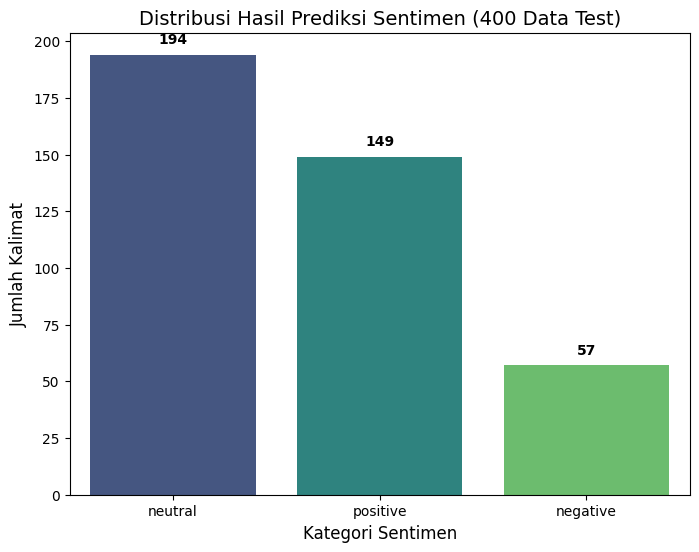

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hitung jumlah tiap sentimen dari hasil tebakan
counts = df_test['sentiment_prediction'].value_counts()

# 2. Buat visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# 3. Tambah judul dan keterangan
plt.title('Distribusi Hasil Prediksi Sentimen (400 Data Test)', fontsize=14)
plt.xlabel('Kategori Sentimen', fontsize=12)
plt.ylabel('Jumlah Kalimat', fontsize=12)

# Tampilkan angka di atas batang
for i, v in enumerate(counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
